
# ISM Toy Model
This notebook generates a 3D cube (8×8×8) containing: \
- An intrinsic (user-defined) POS sinusoidal pattern, which varies in amplitude in the Z direction (LOS).
- Random LOS **turbulence**, which perturbs the resulting POS field, creating depoarization on integration
- Compute Stokes **Q** and **U**
- Computes **Zeeman** from intrinsic (user-defined) Bz strength.
- Estimates **DCF**, POS B field strength, by finding angular dispersion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# === USER-ADJUSTABLE PARAMETERS ===
# Grid size
g_size = 10
# Intensity and intrinsic polarization fraction
I0 = 1.0               # intensity per voxel (constant here)

# POS pattern parameters
frequency = 1.0        # frequency of the sinusoidal variation across the POS
# amplitude = 1.0        # amplitude of the sinusoidal variation across the POS
amplitude = np.linspace(0,1.5,g_size)

# magnetic field strength of Bx, By components:
Bx0 = 1.0              # POS B-field component along x (arbitrary units)
By0 = 1.0              # POS B-field component along y (arbitrary units)

# LOS (Zeeman) magnetic field (true value) and measurement noise
Bz_true = 0.5          # true LOS B-field (arbitrary units, e.g., microgauss) - constant here
zeeman_noise_sigma = 0.3  # Gaussian noise added to simulated Zeeman "measurement"

# Turbulence along LOS: controls angular perturbations (radians)
turb_sigma = 0.15       # larger -> stronger angular perturbations -> more depolarization
corr_r = 1        # AR(1) correlation coefficient along the z-axis (0 = white; close to 1 = highly correlated)

# DCF parameters (arbitrary units). For physical units, set rho and sigma_v appropriately.
rho = 1.0              # mass density (set to 1 for toy model)
sigma_v = 1.0          # LOS velocity dispersion (required by DCF formula)
cf_prefactor = np.sqrt(4 * np.pi * rho) * sigma_v


### Build POS wavy magnetic field with varying amplitude along LOS
- Test depolarization from geometric effects

In [6]:
x = np.linspace(-np.pi, np.pi, g_size)
y = np.linspace(-np.pi, np.pi, g_size)
z = np.linspace(-np.pi, np.pi, g_size)
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

Bx = np.zeros(X.shape)
By = np.zeros(Y.shape)
Bz = np.zeros(Z.shape)

# Sinusoidal Field in POS
# Vary in amplitude along z-axis to test geometric depolarization
for i in range(len(Z)):
    theta0 = amplitude[i] * np.cos(frequency * X[:,:,i])

    Bx[:,:,i] = Bx0*np.cos(theta0)
    By[:,:,i] = By0*np.sin(theta0)
    Bz[:,:,i] = np.ones_like(theta0) * Bz_true

- double check field is built correctly, plot each layer in LOS along Z

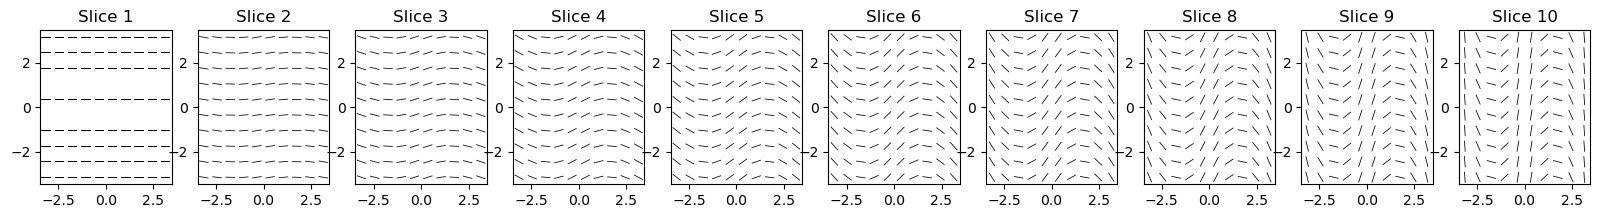

In [7]:
fig, ax = plt.subplots(1, g_size, figsize=(20, 2))
for i in range(g_size):
    ax[i].quiver(
        X[:,:,i], Y[:,:,i],
        Bx[:,:,i], By[:,:,i],
        pivot='middle', scale=2, scale_units='xy',headaxislength=0,
        headlength=0,headwidth=1
    )
    ax[i].set_title(f"Slice {i+1}")

- plot field in 3D

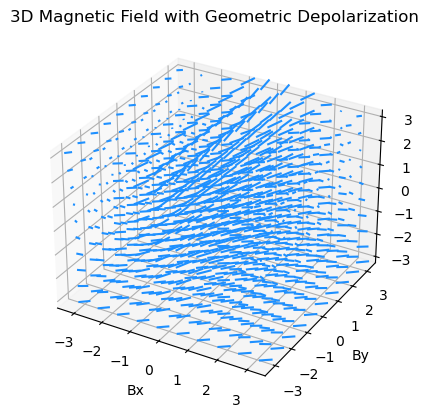

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(X, Y, Z, Bx, By, Bz, length=0.5, normalize=True, 
        arrow_length_ratio=0, color='dodgerblue')
ax.set_xlabel('Bx')
ax.set_ylabel('By')
ax.set_zlabel('Bz')
ax.set_title('3D Magnetic Field with Geometric Depolarization')
plt.show()

### LOS turbulence as random rotation of POS field

In [9]:
delta_theta = np.zeros((g_size, g_size, g_size))

for ix in range(g_size):
    for iy in range(g_size):
        val = np.random.normal(scale=turb_sigma) # generate an initial random turbulent angle, based on turb_sigma - the maximum angular deviation
        for iz in range(g_size):
            delta_theta[ix, iy, iz] = val # fill with current value
            # generate next value using autoregressive model
            val = corr_r * val + np.random.normal(scale=turb_sigma * np.sqrt(1 - corr_r**2)) # AR(1) process
            
# Apply turbulence: rotate POS components
Bx = Bx * np.cos(delta_theta) - By * np.sin(delta_theta)
By = Bx * np.sin(delta_theta) + By * np.cos(delta_theta)
Bz = Bz  # LOS field unaffected by angular turbulence

- check for turbulence added

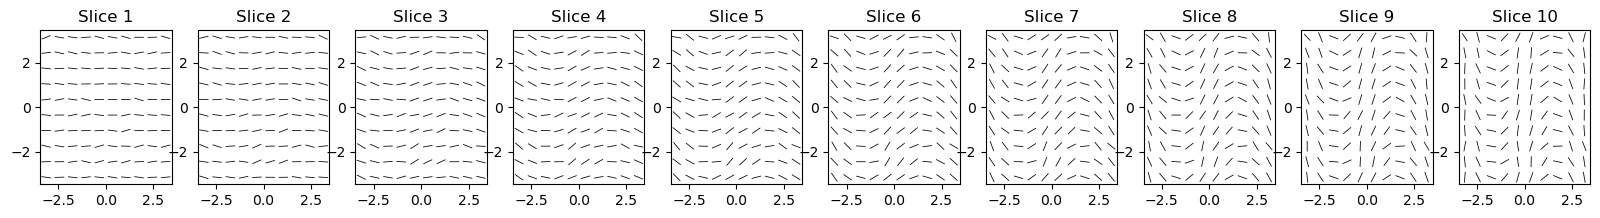

In [10]:
fig, ax = plt.subplots(1, g_size, figsize=(20, 2))
for i in range(g_size):
    ax[i].quiver(
        X[:,:,i], Y[:,:,i],
        Bx[:,:,i], By[:,:,i],
        pivot='middle', scale=2, scale_units='xy',headaxislength=0,
        headlength=0,headwidth=1
    )
    ax[i].set_title(f"Slice {i+1}")

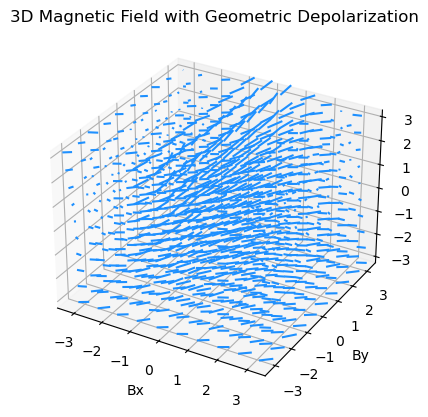

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(X, Y, Z, Bx, By, Bz, length=0.5, normalize=True, 
        arrow_length_ratio=0, color='dodgerblue')
ax.set_xlabel('Bx')
ax.set_ylabel('By')
ax.set_zlabel('Bz')
ax.set_title('3D Magnetic Field with Geometric Depolarization')
plt.show()

### Compute Stokes and Polarization Observables

In [12]:
# === COMPUTE STOKES q, u FROM MAGNETIC FIELD ===
cos2g         = (Bx**2+By**2)/(Bx**2+By**2+Bz**2) # geometrical depolarization
q             = (By**2-Bx**2)/(Bx**2+By**2) * cos2g # Local (unnormalized) Stokes parameters
u             = (2*Bx*By)/(Bx**2+By**2) * cos2g # Local (unnormalized) Stokes parameters

# Include intensity scaling
Q3 = I0 * q 
U3 = I0 * u

# === INTEGRATE ALONG LOS ===
Q_obs = Q3.sum(axis=2) # observed Stokes Q after LOS integration
U_obs = U3.sum(axis=2) # observed Stokes U after LOS integration
I_obs = I0 * g_size  # total intensity after LOS integration (constant here)

# === OBSERVED POLARIZATION PROPERTIES ===
P_obs   = np.sqrt(Q_obs**2 + U_obs**2) / I_obs  # fractional polarization after LOS integration
phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)        # observed polarization angle (radians)


#### Check for depolarization in stokes U and Q map

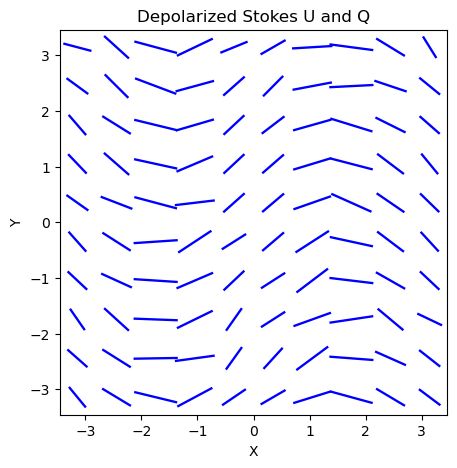

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_title('Depolarized Stokes U and Q')
x = np.sin(phi_obs)*P_obs
y = np.cos(phi_obs)*P_obs
ax.quiver(X[:,:,0], Y[:,:,0], x, y, scale=1, scale_units='xy',headaxislength=0, headlength=0, headwidth=1, pivot='middle', color='blue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

### Add Zeeman information BLOS

In [14]:
# === SIMULATED ZEEMAN MEASUREMENTS (LOS B) ===
Bz_map = np.ones((g_size, g_size)) * Bz_true
# add noise to measurement
zeeman_measured = Bz_map + np.random.normal(scale=zeeman_noise_sigma, size=(g_size, g_size)) 

### DCF (Chandrasekhar-Fermi) estimate of POS field

DCF method finds the plan-of-sky magnetic field strength with:
\begin{align}
    B_{pos} \approx \frac{\sqrt{4\pi \rho}\sigma_{\nu}}{\sigma_{\phi}}
\end{align}
where

$\sigma_{\nu}$ = turbulent velocity dispersion \
$\sigma_{\phi}$ = angular dispersion in POS

- since phi is circular, wrap angles about 180
- find angular dispersion in POS with 3x3 kernel
- compute POS magnetic field strength
- return as DCF value

In [15]:
# Estimate the local angular dispersion sigma_phi from a 3x3 patch of phi_obs around each pixel.
def angular_dispersion(angle_patch):
    """Compute angular dispersion for polarization angles (radians).
    Angles are treated with polarization periodicity (180 deg -> use 2*phi on the circle).
    Returns sigma_phi in radians."""
    a = angle_patch.flatten()
    cx = np.cos(2*a)
    sx = np.sin(2*a)
    C = np.mean(cx)
    S = np.mean(sx)
    R = np.sqrt(C**2 + S**2)
    R = np.clip(R, 1e-8, 1.0)
    sigma = 0.5 * np.sqrt(-2.0 * np.log(R))
    return sigma

# Compute sigma_phi map using a wrapped padding (toroidal) to avoid edge issues for small boxes
pad = 1
phi_padded = np.pad(phi_obs, pad_width=pad, mode='wrap')
sigma_phi_map = np.zeros((g_size, g_size))
for ix in range(g_size):
    for iy in range(g_size):
        patch = phi_padded[ix:ix+3, iy:iy+3] # uses 3x3 kernel in POS
        sigma_phi_map[ix, iy] = angular_dispersion(patch)

# Clip sigma to avoid division by zero and then compute DCF Bpos
sigma_floor = 1e-2
sigma_phi_map_clipped = np.clip(sigma_phi_map, sigma_floor, None)
Bpos_map = cf_prefactor / sigma_phi_map_clipped
DCF_map = Bpos_map # DCF magnetic field estimate map (arbitrary units)


### Plot 3D Field

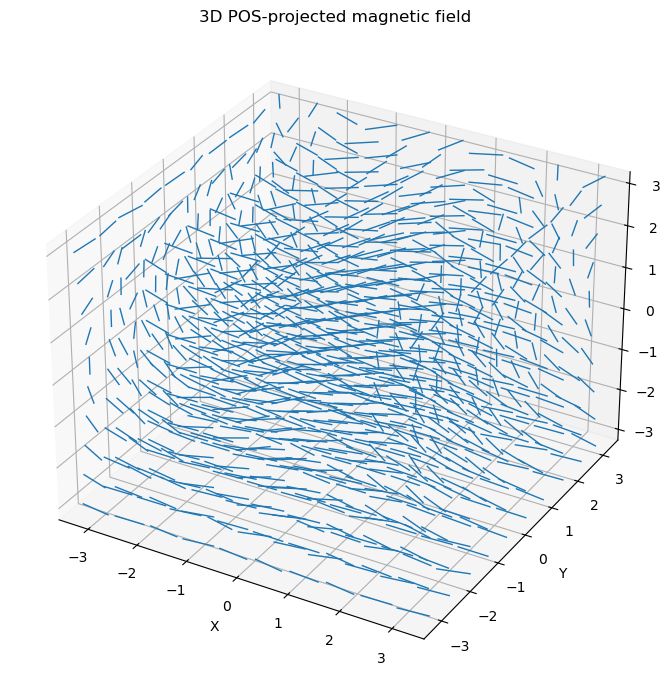

In [16]:
# --- POS-projected magnetic field per voxel ---
# Project B onto POS and apply geometric depolarization
Bx_pos = Bx * cos2g
By_pos = By * cos2g

# Normalize for visualization only (orientation matters, not magnitude)
norm = np.sqrt(Bx_pos**2 + By_pos**2)
norm[norm == 0] = 1.0
Bx_plot = Bx_pos /norm
By_plot = By_pos / norm
Bz_plot = np.zeros_like(Bx_plot)  # POS only

# Subsample for clarity (optional)
step = 1  # increase to thin vectors
Xs = X[::step, ::step, ::step]
Ys = Y[::step, ::step, ::step]
Zs = Z[::step, ::step, ::step]

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(
    Xs, Ys, Zs,
    Bx_plot[::step, ::step, ::step],
    By_plot[::step, ::step, ::step],
    Bz_plot[::step, ::step, ::step],
    length=0.6,
    arrow_length_ratio=0.0,   # <-- headless vectors
    pivot='middle',
    linewidth=1
)

ax.set_title("3D POS-projected magnetic field")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.tight_layout()
plt.show()


### Plot slice of POS

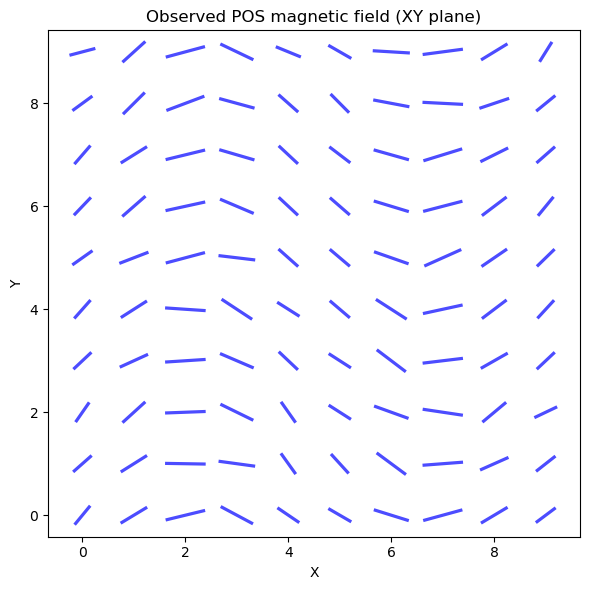

In [17]:
# Observed polarization angle
phi_pol = 0.5 * np.arctan2(U_obs, Q_obs)

# Convert to magnetic-field orientation
phi_B = phi_pol + np.pi / 2

# POS magnetic field components inferred from observables
Bx_obs = P_obs * np.cos(phi_B)
By_obs = P_obs * np.sin(phi_B)

ix = np.arange(g_size)
iy = np.arange(g_size)
XX, YY = np.meshgrid(ix, iy, indexing='xy')

plt.figure(figsize=(6, 6))

plt.quiver(XX, YY, Bx_obs, By_obs, angles='xy', scale_units='xy', scale=1, pivot='middle',
    headwidth=0, headlength=0, headaxislength=0, linewidth=1, color='blue', alpha=0.7)

plt.title("Observed POS magnetic field (XY plane)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Plot maps of observables

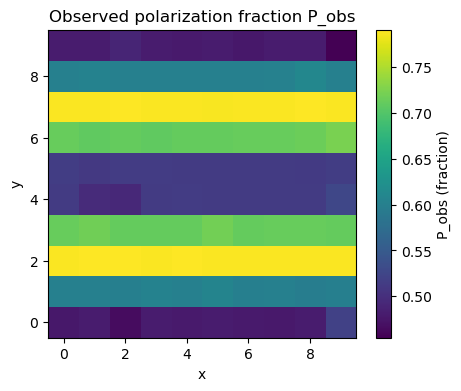

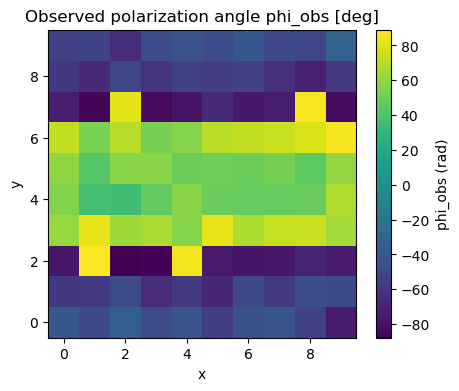

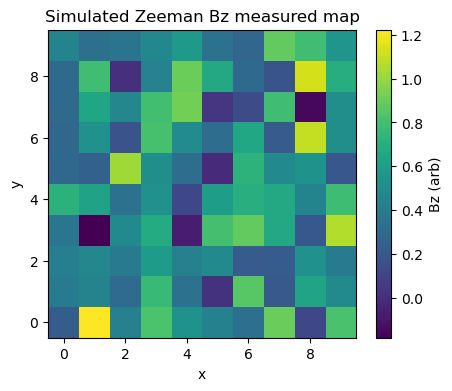

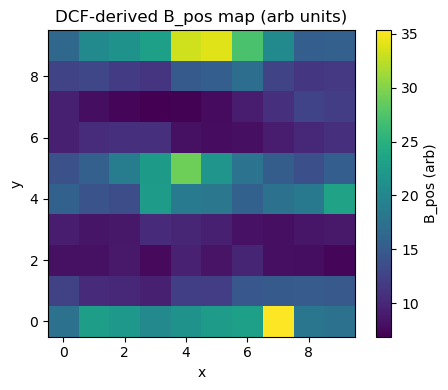

In [18]:

# === PLOTTING: a few diagnostic panels ===
# Each plot is on its own figure to keep things simple and readable.

plt.figure(figsize=(5,4))
plt.title('Observed polarization fraction P_obs')
plt.imshow(P_obs.T, origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='P_obs (fraction)'); plt.xlabel('x'); plt.ylabel('y')

plt.figure(figsize=(5,4))
plt.title('Observed polarization angle phi_obs [deg]')
plt.imshow(phi_obs.T*(180/np.pi), origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='phi_obs (rad)'); plt.xlabel('x'); plt.ylabel('y')

plt.figure(figsize=(5,4))
plt.title('Simulated Zeeman Bz measured map')
plt.imshow(zeeman_measured.T, origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='Bz (arb)'); plt.xlabel('x'); plt.ylabel('y')

plt.figure(figsize=(5,4))
plt.title('DCF-derived B_pos map (arb units)')
plt.imshow(DCF_map.T, origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='B_pos (arb)'); plt.xlabel('x'); plt.ylabel('y')

plt.tight_layout()
plt.show()


### Return:
- Stokes U/Q/I
- Zeeman measurement
- DCF
- Turbulence measure

return Q_obs, U_obs, I_obs, cos2g, P_obs, phi_obs, zeeman_measured, DCF_map